## Plots and analysis to answer research questions

### How are the Hugging Face organizations built (in terms of gender diversity)?
To analyse the organization's composition, we have followed the following steps:
- Fetching from the Hugging Face API the top 1000 most popular models (most downloaded models).

- Grouping by organisations, as there are organisations that have more than one model in the top. From the group by, we kept the more popular model. In this ste, we were left with 363 models.

- Because in the top were users (individual, not being members of any organizations) we took them out and were left with 192 organisations.

- From each organisation we searched all of their members. Again, from the Hugging Face API.

- Then, from every user, we fetched their GitHub user. From there we could retreive the location of that member.

- Having the HF user's name and location we used an LLM to determine the gender of that user.

In [10]:
import pandas as pd
df = pd.read_csv("organisations_summary.csv")
df['num_users'] = df['num_users'].astype('Int64')

users = 0
max = 0
min = 1000
for index, row in df.iterrows():
    num_users = row['num_users']
    users += num_users
    if num_users > max:
        max = num_users
    if num_users < min:
        min = num_users

mean_users = users/len(df)
print("Total number of users:", users)
print("Mean number of members", mean_users)
print("Maximum number of organization members", max)
print("Minimum number of organization members", min)

Total number of users: 14988
Mean number of members 78.0625
Maximum number of organization members 2125
Minimum number of organization members 1


In [14]:
women = 0
max = 0
min = 1000
women_percentage = 0
for index, row in df.iterrows():
    num_women = row['num_females']
    per_women = row['% of women']
    women_percentage += per_women
    women += num_women
    if per_women > max:
        max = per_women
    if per_women < min:
        min = per_women

mean_perc_women = women_percentage/len(df)
print("Total number of women:", women)
print("Mean percentage of women in HF organisations:", mean_perc_women)
print("Maximum % of female members in an organization:", max)
print("Minimum % of female members in an organization:", min)

Total number of women: 1808
Mean percentage of women in HF organisations: 8.081666666666667
Maximum % of female members in an organization: 50.0
Minimum % of female members in an organization: 0.0


### Does the popularity (in terms of downloads) of a model have a relation with the gender diversity in the organization developing it?
We assume every user in an organisation can be a model developer.

In [2]:
import pandas as pd
import numpy as np

models = pd.read_csv("models_info.csv")
org_summary = pd.read_csv("organisations_summary.csv")

In [3]:
df = pd.merge(models, org_summary, on='organization', how='right')
df = df.sort_values(by='downloads', ascending=False)

In [4]:
df.to_csv('test.csv', index=False)

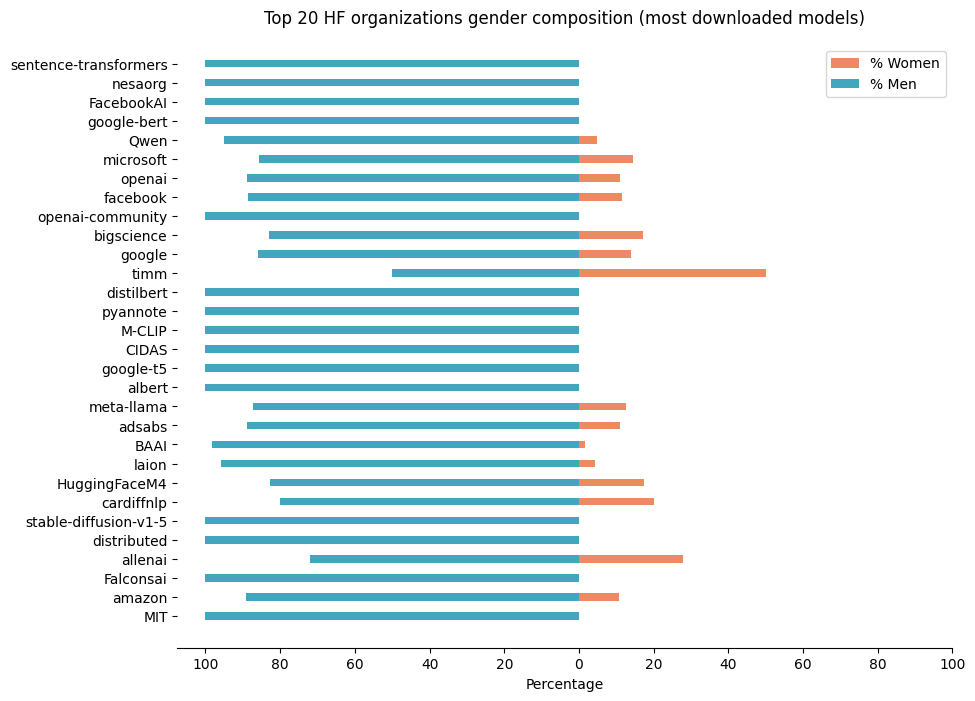

In [5]:
import matplotlib.pyplot as plt

df = df.head(30)
df["% of men"] = 100 - df["% of women"]

df = df.sort_values(by="downloads", ascending=True)
labels = df["organization"]
women_values = df["% of women"]
men_values = df["% of men"]

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(labels, women_values, color='#ec8b62', label='% Women', height=0.4)
ax.barh(labels, -men_values, color='#43A5BE', label='% Men', height=0.4)

ax.set_xlabel('Percentage')
ax.set_title('Top 20 HF organizations gender composition (most downloaded models)')
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.98), ncol=1)

xticks = np.arange(-100, 101, 20)
ax.set_xticks(xticks)
ax.set_xticklabels([abs(x) for x in xticks])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

### How is the behaviour of participants (in terms of commits contribution) inside a Hugging Face model?
#### Are the main commiters men or women?

In [ ]:
import os
import pandas as pd

# Rename CSV files
def rename_csv_files(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv_complete.csv") and filename.startswith("GHlocation_"):
            
            new_name = filename.split("_")[1].split(".")[0] + ".csv"
            old_path = os.path.join(folder_path, filename)
            new_path = os.path.join(folder_path, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} -> {new_name}")

folder_path = "/home/maria/Escriptori/I2RCED/i2rced/organisations/complete_organisations"

rename_csv_files(folder_path)

In [ ]:
def check_author_gender(csv_path, folder_path):
    input_df = pd.read_csv(csv_path)
    results = []

    for _, row in input_df.iterrows():
        organization_name = row['model_id'].split('/')[0]

        organization_csv_path = os.path.join(folder_path, f"{organization_name}.csv")
        
        if os.path.exists(organization_csv_path):
            org_df = pd.read_csv(organization_csv_path)

            author_name = row['authors']
            author_gender = org_df.loc[org_df['username'] == author_name, 'gender'].values
            if author_gender.size > 0:
                gender = author_gender[0]
            else:
                gender = "Unknown"

        else:
            gender = "Organization CSV not found"

        results.append({
            "model_id": row['model_id'],
            "organization": organization_name,
            "author": row['authors'],
            "count": row['commit_count'],
            "gender": gender
        })

    results_df = pd.DataFrame(results)
    return results_df

df2 = "author_commit_count_by_model.csv"
author_commits_gender = check_author_gender(df2, folder_path)


output_path = "author_commits_gender.csv"
#author_commits_gender.to_csv(output_path, index=False)

Results saved to author_commits_gender.csv


After removing all those commits that are not from organisations (models that are developed by individuals), this is the commits distribution by gender:

In [28]:
data = pd.read_csv("author_commits_gender.csv")

In [29]:
import altair as alt

# Prepare the data: Top 20 authors by the number of rows they appear in
top_authors_by_rows = data['author'].value_counts().head(30).reset_index()
top_authors_by_rows.columns = ['author', 'row_count']

# Create the Altair chart
chart = alt.Chart(top_authors_by_rows).mark_bar().encode(
    x=alt.X('row_count:Q', title='Models'),
    y=alt.Y('author:N', sort='-x', title='Author'),
    tooltip=[
        alt.Tooltip('author:N', title='Author'),
        alt.Tooltip('row_count:Q', title='Models')
    ]
).properties(
    title='Top 30 Authors by Number of Models they Commited in',
    width=800,
    height=400
).interactive()

# Display the chart
chart.show()

alt.Chart(...)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

top_authors = data.groupby('author')['count'].sum().sort_values(ascending=False).head(15).reset_index()
top_authors.columns = ['author', 'total_commits']

chart = alt.Chart(top_authors).mark_bar().encode(
    x=alt.X('author:N', title='Author', sort='-y'),
    y=alt.Y('total_commits:Q', title='Total Commits'),
    tooltip=[
        alt.Tooltip('author:N', title='Author'),
        alt.Tooltip('total_commits:Q', title='Total Commits')
    ]
).properties(
    title='Top 15 Authors by Total Commits',
    width=800,
    height=400
).configure_axis(
    labelAngle=45  
).interactive()

chart.show()

alt.Chart(...)

In [ ]:
import altair as alt

gender_distribution = data.groupby('gender')['count'].sum().reset_index()

colors = ['#ff9999', '#66b3ff', '#99ff99']

chart = alt.Chart(gender_distribution).mark_arc(innerRadius=100).encode(
    theta=alt.Theta(field='count', type='quantitative', stack='zero'),
    color=alt.Color('gender:N', scale=alt.Scale(domain=['male', 'unknown', 'female'], range=colors)),
    tooltip=['gender:N', 'count:Q']
).properties(
    title='Distribution of Commits by Gender',
    width=400,
    height=400
).configure_view(
    stroke=None
).interactive()

chart.show()

alt.Chart(...)